# Predicting Hard Drive Failure (Daniela)

Hard Drive failure can have a negative impact, be it for a private persons loss of valuable memories or technical failure of mass storage companies. While individual persons mostly only rely on one individual hard drive and might not possess a back-up of their data, data storage facilities apply regular backup measures to prevent loss of data.  
However, hard drives are clustered into "storage pods" (servers that group 60 hard drives) and thus, "it is necessary [...] to anticipate such failures as a single failing hard drive could impede the whole storage pod’s operation." (Amram M., Dunn J., Toledano J. J. & Zhuo, Y. D. (2021). Interpretable predictive maintenance for hard drives. *Machine Learning with Applications 5 (2021) 100042*)

<br>

### The Data

For this project we are using the data from Blackblaze, a large data storage provider with roughly 200.000 hard drives. (11.03.2022)

All of the hard drives within their storage facility communications everyday a range of [S.M.A.R.T. (Self-Monitoring, Analysis and Reporting Technology)](https://en.wikipedia.org/wiki/S.M.A.R.T.) features, which have the main function to report indicators about the drive reliability with the intent of identifying imminent hard drive failure.  

Some examples of SMART features that are marked as important are:
* 05 - Reallocated Sectors Count
* 10 - Spin Retry Count
* 184 - End-to-End error / IOEDC
* 187 - Reported Uncorrectable Errors
* 188 - Command Timeout

During the EDA we look further into the SMART features that are most important and will provide further information about the features, which are playing an important role in our analysis.

The amount of SMART features, as well which SMART features are communicated differes from year to year (can also differ from Quarter to Quarter), as well as from hard drive to hard drive. Also different brands might communicate different values for the same feature, making a overall comparison challenging.

In addition, the date, serial_number, model, capacity_bytes as well as the failure column are added to the data, where failure is either a 0 (no failure) or 1 (failure).

As the amount of data is quiet large, a Google Cloud SQL Instance is used to save the data temporarily and only relevant parts are queried when needed. However, even with this the decision was made to focus only on a specific time period for this project. Thus, we only take data from 2019 to 2021 into consideration.

The data can be found [here](https://www.backblaze.com/b2/hard-drive-test-data.html).

As the Google Cloud Instance is only temporarily available we also shortly explain what data we used for which part of our project, so that a replication is possible, when having the data obtained.

### Our hypotheses

<br>
<br>

## Exploratory Data Analysis (EDA) and Data Pre-processing

We start by loading the necessary libraries for the EDA as well as loading the data for the first quarter of 2021 and start getting some basic insights.

The first quarter will be loaded directly from the CSV files. This way we can start our first EDA on the overall dataset and get some insights and make the decision in which direction we want to move.

However, we still directly establish the connection to our data base in the beginning, so that we are able to query and data from 2019 to 2021 when needed.

In [256]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import os

from tqdm import tqdm  
from time import sleep 
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.feature_selection import mutual_info_classif

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(rc={'axes.facecolor':'#fae5d2', 'figure.facecolor':'white'})

RSEED = 42

In [7]:
# access the database
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

In [8]:
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

In [9]:
# creating the query and loading some test data into a pandas data frame
query_string = 'SELECT * FROM public."2021" LIMIT 10'
df = pd.read_sql(query_string, conn)
df.head(2)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2020-09-18,40P0A05UF97G,TOSHIBA MG07ACA14TA,14000519643136,0,100,0,100.0,0.0,100,...,None,None,None,None,None,None,None,None,None,None
1,2020-09-18,88P0A0BZF97G,TOSHIBA MG07ACA14TA,14000519643136,0,100,0,100.0,0.0,100,...,None,None,None,None,None,None,None,None,None,None


## Getting data and some insights

Due to the size of the data set we focus on one quarter and take the first quarter of 2021 as a starting point for our EDA.

The data for the first quarter was combined in a CSV file (the code to load the individual files is commented out, but can be re-run if needed) and for convenience we load the data directly from the combined data frame for Q1.

Alternatively, we also have the possibility to query that data directly from the SQL database using the established connection.

In [5]:
# # concatenate the files per day on quarter basis and input the date column as date format
# for i in range(1, 5):
#     path = rf'../data/raw/data_Q{i}_2021'
#     all_files = glob.glob(os.path.join(path, "*.csv"))

#     df_from_each_file = (pd.read_csv(f,parse_dates=["date"]) for f in all_files)
#     concatenated_df = pd.concat(df_from_each_file, ignore_index=True)

#     concatenated_df.to_csv(f'../data/interim/data_q{i}.csv', index=False)

In [65]:
# load the q1 data set from CSV file
q1 = pd.read_csv('../data/interim/data_q1.csv', parse_dates=['date'])

In [67]:
# display the first couple of entries
display(q1.head(2))
display(q1.tail(2))
print(q1.shape)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-03-25,ZHZ65F2W,ST12000NM0008,12000138625024,0,82.0,162621344.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-25,ZLW0EGC7,ST12000NM001G,12000138625024,0,72.0,14988480.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
15287370,2021-03-28,ZA13ZBCT,ST8000DM002,8001563222016,0,77.0,49613768.0,NaN,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15287371,2021-03-28,X0GEV9EC,WDC WUH721414ALE6L4,14000519643136,0,100.0,0.0,138.0,95.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(15287372, 149)


Our Q1 2021 data consists of ~15.000.000 entries with 149 features. Out of these 144 are SMART features, which are statistics communicated directly by the hard drive.

After loading the data set and inspecting the first/last observations within the data frame, we shortly look into the alternative columns we have available and also inspect our potential target variable 'failure').

Date: Timestamp added from Blackblaze for the individual days
Serial_Number: Unique identifier per hard drive
Model: the model of the hard drive
Capacity_bytes: the storage capacity per hard drive
Failure: 0 (no failure) or 1 (failure)

In [68]:
# Look at the amount of hard drives reported
q1.query('date == "2021-03-31"')['serial_number'].nunique()

175443

In [69]:
q1.failure.value_counts()

0    15286972
1         400
Name: failure, dtype: int64

As mentioned we have for each hard drive in use one observation per day. Thus, at the end of march 2021 roughly 175.000 hard drives are reported per day.

As we have many healthy observations, but likely not that many failures, next we need to understand if we are dealing with a balanced or unbalanced dataset.

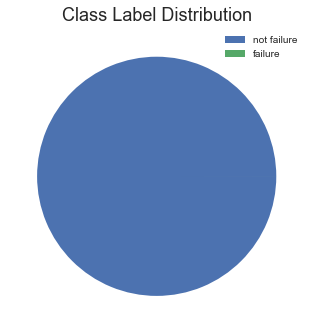

In [9]:
plt.pie(q1.failure.value_counts())
plt.legend(['not failure', 'failure'])
plt.title('Class Label Distribution', fontsize=18);

From this plot it is already quiet clear that we are dealing with a strongly imbalanced data set. As there are multiple ways to approach this, we decided further down the road which approach is reasonable, after we gained some initial insight after the first EDA.

Before we move to the target variable, we are looking at some basic descriptive statistics, data types and potential of missing data.

In [71]:
# create a data frame with all descriptive statistics for the Q1 data set
descriptive_stats = q1.describe().T

# query the data frame for columns which do not have entries    
descriptive_stats.query('count == 0')

,count,mean,std,min,25%,50%,75%,max
smart_15_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_15_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_250_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_250_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_251_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_251_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_252_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_252_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_255_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_255_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With this we already see that some smart features do not contain any information at all and we can drop them directly to reduce the amount of features within the data set.

In [72]:
columns_to_drop = descriptive_stats.query('count == 0').reset_index()['index'].to_list()
q1.drop(columns_to_drop, axis=1, inplace=True)

However, we likely still have missing values within our data set, so let us have a look at this.

In [73]:
missing_values = q1.isnull().sum()

In [74]:
missing_values = missing_values.reset_index()
missing_values.columns = ['smart', 'count']

In [75]:
missing_values.sort_values('count').query('count != 0')

,smart,count
5,smart_1_normalized,20885
6,smart_1_raw,20885
79,smart_194_normalized,20886
80,smart_194_raw,20886
25,smart_12_normalized,20886
...,...,...
134,smart_247_raw,15287227
135,smart_248_normalized,15287227
136,smart_248_raw,15287227
100,smart_210_raw,15287227


Across all models we have 134 features with missing values. However, some columns have over 15 Mio missing entries and so these features are almost completely redundant for this data set. However, we are not going to drop them now. As we are selecting a special model, we will verify than which features are relevant and drop the others.

In [4]:
#q1.to_csv('../data/interim/data_q1_NaN.csv', index=False)
q1 = pd.read_csv('../data/interim/data_q1_NaN.csv')
q1.shape

(15287372, 139)


As a next step, we check the different hard drive models that we have in the data set ('model') to understand how the different types are represented and if there are different possibilities of failure per model.

In [5]:
# create a list based on the sorted model frequency (highest to lowest) to use for plotting
model_frequency = q1.model.value_counts().reset_index().iloc[:,0].to_list()

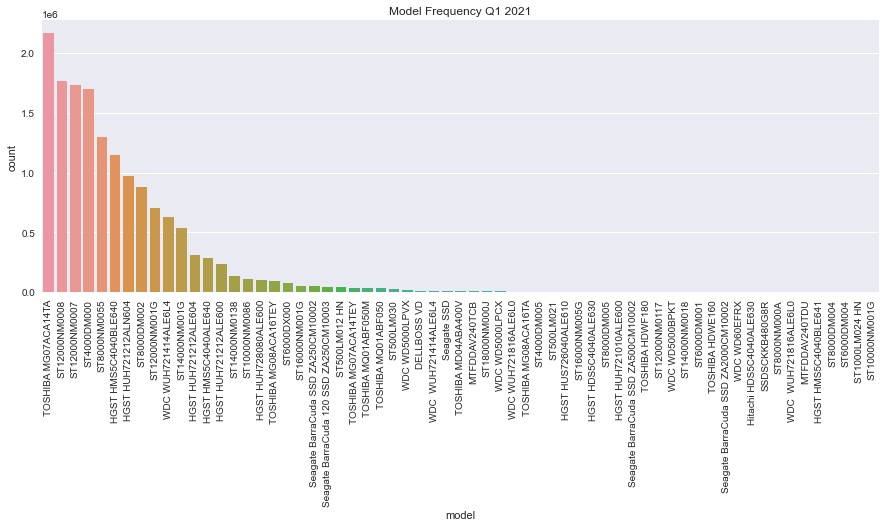

In [10]:
# look at the distribution of the different hdd models
plt.figure(figsize=(15, 5))
g = sns.countplot(q1.model, order=model_frequency)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Model Frequency Q1 2021');

As we have many different models and the graphic is getting a bit crowded, we look again at the Top 15 of the hard drives and will also focus on the Top 15 to look into the failure rate and for the further analysis we also focus on the Top 15 hard drive models.

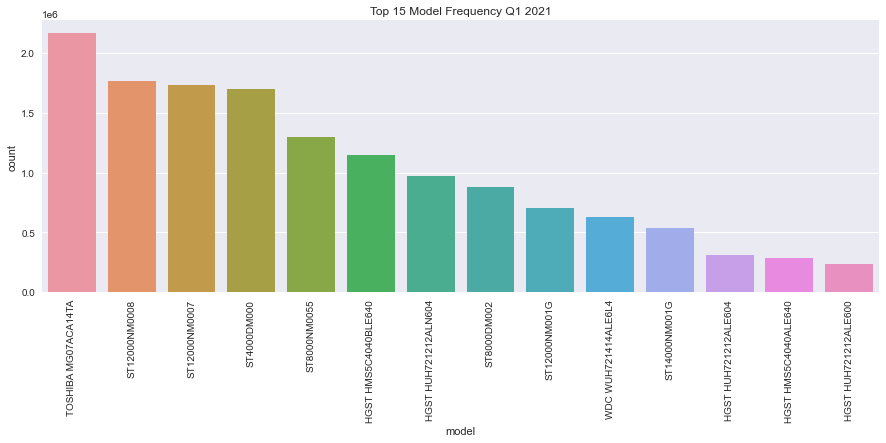

In [11]:
# look at the distribution of the different hdd models
plt.figure(figsize=(15, 5))
g = sns.countplot(q1.model, order=model_frequency[0:14])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 15 Model Frequency Q1 2021');

With this we get some insight into the frequency per model within out dataset and while this might change over time and the overall representation could be slightly differ, we still are going to select one of the models which is most often represented to go deeper into our EDA. This way we can select one model, but a longer time frame to understand more about the development over time.

In [12]:
# create a separate data frame with only failed data
failure_q1 = q1.query('failure == 1')

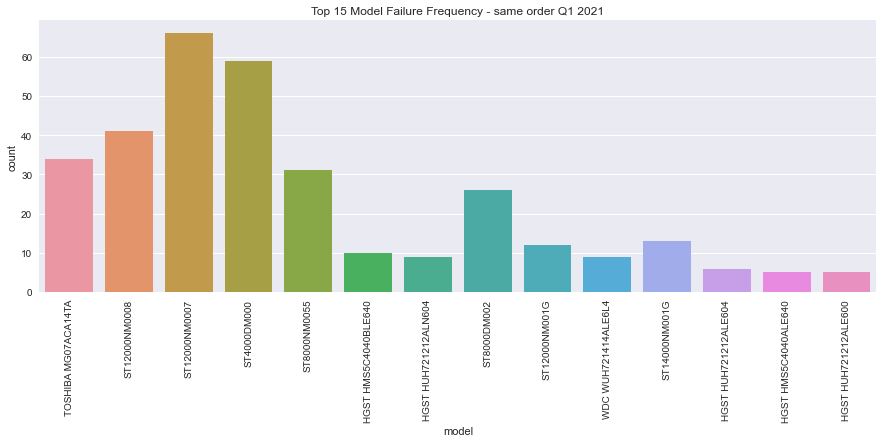

In [13]:
# plot the failure frequency per model in the same order as previous plot
plt.figure(figsize=(15, 5))
g = sns.countplot(failure_q1.model, order=model_frequency[0:14])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 15 Model Failure Frequency - same order Q1 2021');

We see that the higher represented models also have more total failures. For the last plot we kept the original Top 15 order, but next we order the plot again based on the highest total failure number per model.

In [15]:
# create a new column order list based on failure frequency / ignores models without any failure in Q1
failure_frequency = failure_q1.model.value_counts().reset_index().iloc[:,0].to_list()

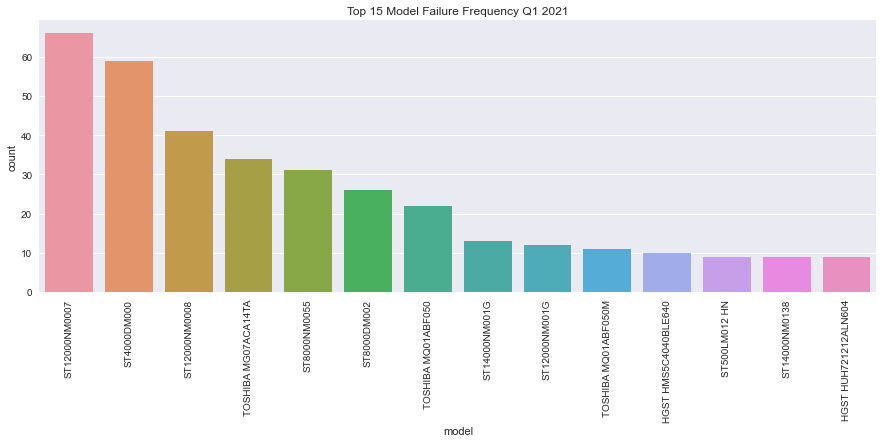

['ST12000NM0007',
 'ST4000DM000',
 'ST12000NM0008',
 'TOSHIBA MG07ACA14TA',
 'ST8000NM0055']

In [16]:
# plot failure frequency bt model type descending
plt.figure(figsize=(15, 5))
g = sns.countplot(failure_q1.model, order=failure_frequency[:14])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 15 Model Failure Frequency Q1 2021');
plt.show()

# print the Top 5 failure list
failure_frequency[:5]

For the Q1 data set, the ST1200NM0007 has the highest total amount of failures, closely follow by the ST4000DM000.

However, as this might not indicate a higher percentage failure, we look into the percentage distribution of the failures per hard drive next.

In [17]:
most_failure = q1.query('model == "ST12000NM0007" or model == "ST4000DM000" or model == "ST12000NM0008" or model == "TOSHIBA MG07ACA14TA" or model == "ST8000NM0055"')

In [42]:
# create a crosstab for the index=country with the proporatons 
cross_tab_prop_failure = pd.crosstab(index=most_failure['model'],
                             columns=most_failure['failure'],
                             normalize="index")

# create a crosstab for the index=country on total values
cross_tab_failure = pd.crosstab(index=most_failure['model'],
                        columns=most_failure['failure'])

cross_tab_prop_failure.reset_index(inplace=True)
cross_tab_prop_failure.sort_values(1, ascending=False, inplace=True)

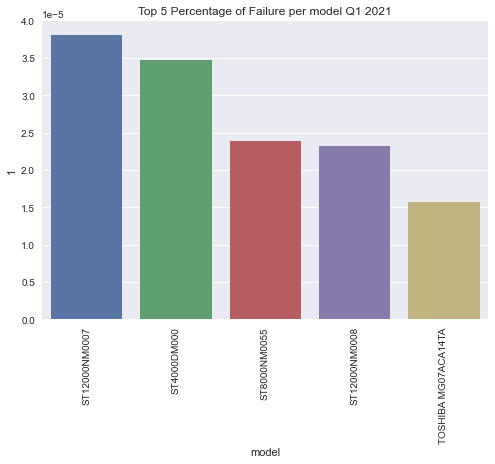

In [43]:
g = sns.barplot(data=cross_tab_prop_failure, x='model', y=1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 5 Percentage of Failure per model Q1 2021')
plt.savefig('../images/failure_percentage_top5', bbox_inches = "tight");

In [44]:
# create a crosstab for the index=country with the proporatons 
cross_tab_prop_failure_total = pd.crosstab(index=q1['model'],
                             columns=q1['failure'],
                             normalize="index")

# create a crosstab for the index=country on total values
cross_tab_failure_total = pd.crosstab(index=q1['model'],
                        columns=q1['failure'])

cross_tab_prop_failure_total.reset_index(inplace=True)
cross_tab_prop_failure_total.sort_values(1, ascending=False, inplace=True)

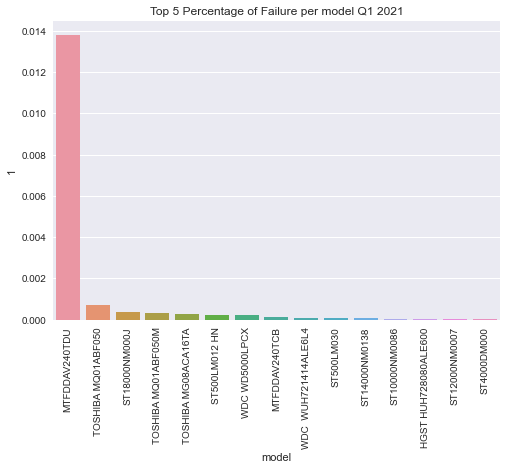

In [45]:
g = sns.barplot(data=cross_tab_prop_failure_total[:15], x='model', y=1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 5 Percentage of Failure per model Q1 2021')
plt.savefig('../images/failure_percentage_top5', bbox_inches = "tight");

MTFDDAV240TDU has definitely the highest failure percentage per model. However, this model has not been that present, so we next check how often this model appears in the data set.

In [49]:
q1.query('model == "MTFDDAV240TDU"').shape

(145, 150)

So while it definitely has a high chance of failure, it is also completely underrepresented within our dataset. To make the decision which model we will put into the focus of our analysis, we will therefore focus on one of the models which has a high total appearance, as well as a significant amount of failures.

In [50]:
highest_appearance_total = pd.read_sql("""
        SELECT model, COUNT(model)
        FROM public."2021" 
        GROUP BY model
        ORDER BY count DESC
        """, conn)

highest_appearance_total.iloc[:5,]

highest_appearance_total.to_csv(f'../data/special_purpose/highest_appearance_total.csv', index=False)

,model,count
0,ST12000NM0007,27469429
1,ST4000DM000,21184657
2,TOSHIBA MG07ACA14TA,16326017
3,ST8000NM0055,15797997
4,HGST HMS5C4040BLE640,13997926


In [ ]:
highest_failure_total = pd.read_sql("""
        SELECT model, COUNT(model), failure
        FROM public."2021" 
        GROUP BY model, failure
        HAVING failure = '1'
        ORDER BY count DESC
        """, conn)

highest_failure_total.iloc[:5,]

highest_failure_total.to_csv(f'../data/special_purpose/highest_failure_total.csv', index=False)

,model,count,failure
0,ST4000DM000,610,1
1,ST12000NM0007,494,1
2,ST8000NM0055,392,1
3,ST12000NM0008,366,1
4,TOSHIBA MG07ACA14TA,347,1


As already stated, the hard drive models communicate different SMART features based on model/brand and even if the similar features are communicated, the values differ based on model.

Thus, we are focusing only on one hard drive model and while the ST12000NM0007 has a higher total amount of hdd drives within the data set, the ST4000DM000 has actually a higher value of failures within our data.  
As we are going to use only the hard drive data for drives that will eventually fail, we are selecting the ST4000DM000 as our data set and focus on this hard drive for the next step.

But before we move to the data pre-processing and baseline model, we look further into our data and work on the previously stated hypotheses.

### Hypotheses

- The chosen HDD model (Seagate ST4000DM000) is the superior one. (3-4 of the others - 4Tb, 2Tb, 1Tb, 512Gb)
- The hard drives will fail after about 3 years of constant usage at maximum.
- Hard drive failing probability is dependent on the available space of the disk type.

### The chosen HDD model (Seagate ST4000DM000) is the superior one. 

As the first hypothesis states, we assume that our model which we look into is superior to other models. We do this by comparing the failed hard drives only, so that we can get insights into how often and how fast they fail.

While we already saw that the percentage of failure is quiet high, we want to check if the model is superior in other terms, e.g. that the life expectancy is higher than for other models.

To do this we look further into the time related parameters, in this case smart_9_raw (Power-On Hours).


In [4]:
failure = pd.read_sql("""
        SELECT *
        FROM public."2021" 
        WHERE failure == 1
        """, conn)

failure.to_csv(f'../data/special_purpose/failure.csv', index=False)

# load the data set solely for failing hard drives
failure = pd.read_csv('../data/special_purpose/failure.csv')

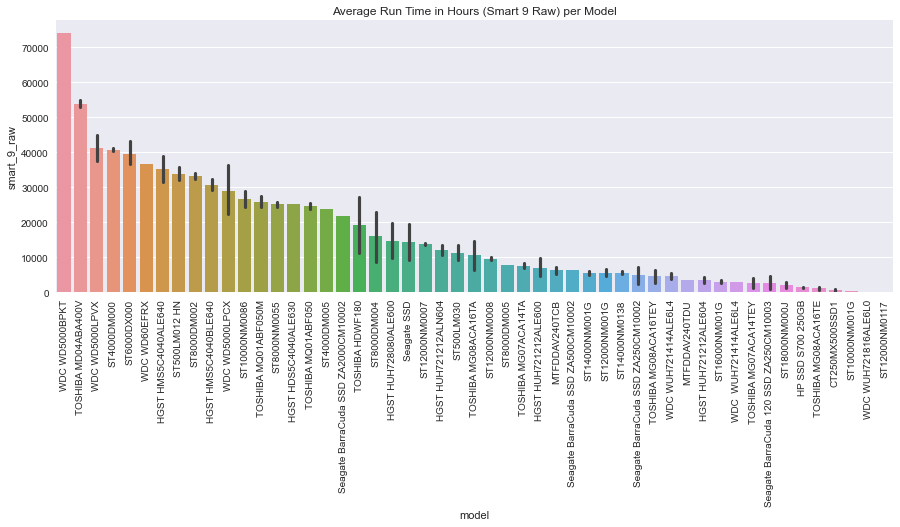

In [75]:
# create a sorted column for the smart 9 feature
smart_9 = failure.groupby('model').mean()['smart_9_raw'].reset_index().sort_values('smart_9_raw', ascending=False).iloc[:,0].to_list()

# plot the average time
plt.figure(figsize=(15,5))
g = sns.barplot(failure['model'], failure['smart_9_raw'], order=smart_9)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Average Run Time in Hours (Smart 9 Raw) per Model');

As a short reminder we are going to call the percentage failure plot again, where we can see how often the Top 5 represented models fail.

In [53]:
# create a crosstab for the index=country with the proporatons 
cross_tab_prop_failure = pd.crosstab(index=most_failure['model'],
                             columns=most_failure['failure'],
                             normalize="index")

# create a crosstab for the index=country on total values|
cross_tab_failure = pd.crosstab(index=most_failure['model'],
                        columns=most_failure['failure'])

cross_tab_prop_failure.reset_index(inplace=True)
cross_tab_prop_failure.sort_values(1, ascending=False, inplace=True)

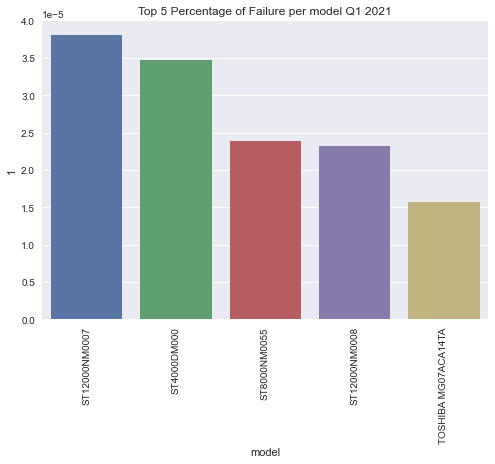

In [54]:
g = sns.barplot(data=cross_tab_prop_failure, x='model', y=1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 5 Percentage of Failure per model Q1 2021')
plt.savefig('../images/failure_percentage_top5', bbox_inches = "tight");

For the first hypothesis we were looking into the superiority of our chosen hard drive model and while it does not have the highest failure rate for the Top 5 represented hard drives within the data set (Q1 2021) it is a close second.

This means in terms of failure per hard drive model, this model does not seem to hold too much superiority. If we discard the total amount of the hard drives per data set, our selected hard drive is only on spot 15 of our hard drive, but the result is less comparable.

However, in terms of run time, our model holds a good spot, especially as it has a significant representation within our data.

Still, there are models which show a higher run time and a lower failing percentage. Therefore, we conclude that our hard drive is not superior to other models.

<br>

### The hard drives will fail after about 3 years of constant usage at maximum.

The normal life cycle of a hdd is set to roughly 3 years. Thus, we check if our data shows similar behavior to understand at what age the hard drives fail within our data set. We again look into smart_9_raw for this hypothesis.

In [5]:
# create a new column logging the run time in days instead of hours
failure['age_in_days'] = failure['smart_9_raw'] / 24

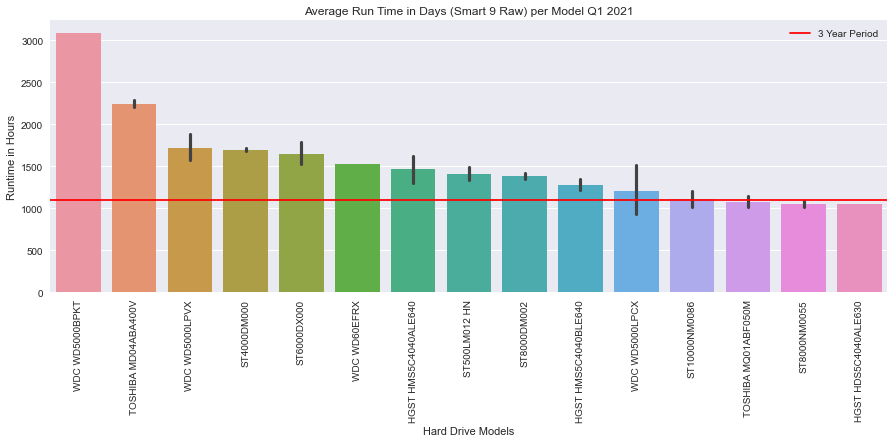

In [10]:
# create a sorted column for the smart 9 feature
smart_9 = failure.groupby('model').mean()['age_in_days'].reset_index().sort_values('age_in_days', ascending=False).iloc[:,0].to_list()

# plot the average time
plt.figure(figsize=(15,5))
g = sns.barplot(failure['model'], failure['age_in_days'], order=smart_9[:15])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.axhline(y=3*365.25, c='r', label='3 Year Period')
#plt.axhline(y=failure['age_in_days'].mean(), c='k', label='Mean')
plt.legend(loc="upper right")
plt.ylabel('Runtime in Days')
plt.xlabel('Hard Drive Models')
plt.title('Average Run Time in Days (Smart 9 Raw) per Model Q1 2021')
plt.savefig('../images/run_time', bbox_inches = "tight");

### Hard drive failing probability is dependent on the available space of the disk type.

In [51]:
# create a new column containing the size in GB
failure['capacity_gigabytes'] = ((failure['capacity_bytes'] / 1073741824).round(0)).astype('int')

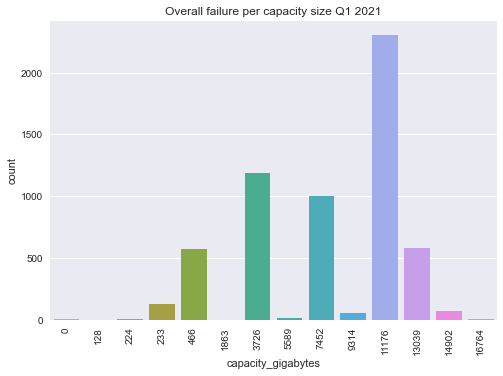

In [77]:
# create a countplot representing the size for the failure drives
g = sns.countplot('capacity_gigabytes', data=failure)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Overall failure per capacity size Q1 2021');

We see that there are differences in failure frequency, however no strong trend is to be identified. Thus, we again will look into the full Q1 2021 data set, to see if we can identify a trend for the overall data.

In [11]:
q1['capacity_gigabytes'] = ((q1['capacity_bytes'] / 1073741824).round(0)).astype('int')

<AxesSubplot:xlabel='capacity_gigabytes', ylabel='count'>

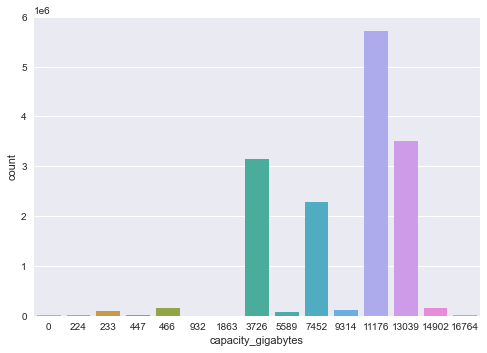

In [79]:
sns.countplot(q1['capacity_gigabytes'])

Larger disks are definitely stronger represented, and everything below 2000GB is highly underrepresented.

In [80]:
# create a crosstab for the index=country with the proporatons 
cross_tab_prop_failure_bytes = pd.crosstab(index=q1['capacity_gigabytes'],
                             columns=q1['failure'],
                             normalize="index")

# create a crosstab for the index=country on total values
cross_tab_failure_bytes = pd.crosstab(index=q1['capacity_gigabytes'],
                        columns=q1['failure'])

cross_tab_prop_failure_bytes.reset_index(inplace=True)
cross_tab_prop_failure_bytes.sort_values(1, ascending=False, inplace=True)

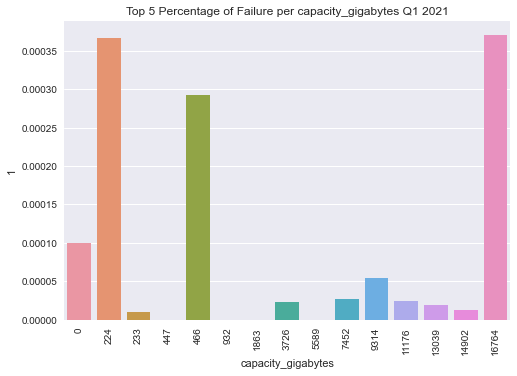

In [81]:
g = sns.barplot(data=cross_tab_prop_failure_bytes, x='capacity_gigabytes', y =1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 5 Percentage of Failure per capacity_gigabytes Q1 2021')
plt.savefig('../images/failure_capacity_top5', bbox_inches = "tight");

Interestingly...

Conclusion 3rd hypothesis

<br>
<br>
<br>
<br>



### ST4000DM000 - Data Processing and EDA

After having decided on a specific hard drive modelwe start by loading the full failure data set and a random sample of hard drives where we know that they will fail at one point in time, but where the failure has not yet been noted.

We do this in order to get a data frame, which we can wrangle and inspect as much as we want without having the troubles of big data frames.

We use this data frame to look into some of the features, to understand correlations and distribution and to decide which features to drop.

As a more in depth overview, we also have the info what the features are referring to next:

Description of the features  
...  
...  
...  
...  
...  



In [18]:
# load the test_model data for failures and success into specific data frames
test_model_failure = pd.read_csv('../data/special_purpose/ST4000DM000_failure.csv', parse_dates=['date'])
test_model_history = pd.read_csv('../data/special_purpose/ST4000DM000_history.csv', parse_dates=['date'])

# choose a random sample of the test_model_history to look into the correlation of features
test_model_success = test_model_history.query('failure == 0').sample(1000)

# concat the two separate data frames into one data frame
test_model_total = pd.concat([test_model_failure, test_model_success], axis=0)
test_model_total.reset_index(inplace=True)

test_model_total.drop('index', axis=1, inplace=True)
test_model_total.shape

(1610, 179)

In [19]:
# create a data frame for the overviw about the isnull values and a series containing the total count of the data frame
isnull = test_model_total.isnull().sum().reset_index(name='isnull')
total = pd.Series([test_model_total.shape[0] for _ in range(len(isnull))])

# create a dictionary and concat the the data to the data frame
data = {'isnull': isnull, 
        'total': total}

isnull = pd.concat(data, axis=1, ignore_index=True)

# give meaningful column names
isnull.columns = ['columns', 'isnull', 'total']

# add extra column containing the percentage of missing data per column
isnull['percentage_of_missing'] = isnull['isnull'] / isnull['total'] * 100

# create a list containing the column names which have more than specified percentage of missing values
drop_columns = isnull.query('percentage_of_missing > 40')['columns'].to_list()
len(drop_columns)

# drop the columns with too much missing values from the data frame
test_model_total.drop(drop_columns, axis=1, inplace=True)
test_model_total.shape

(1610, 53)

In [20]:
# drop 5 rows which do not contain any smart data
test_model_total.dropna(how='any', inplace=True)
test_model_total.shape

(1610, 53)

#### Correlation Matrix

In [21]:
# check columns which only contain 0 values and drop them from the data frame
drop_columns = test_model_total.describe().T.query('mean == 0').reset_index()['index'].to_list()
test_model_total.drop(drop_columns, axis=1, inplace=True)

In [22]:
# construct correlation matrix
corr_mat = test_model_total.corr()

# drop columns which have no correlation at all
drop_columns = corr_mat[corr_mat['failure'].isnull()].reset_index()['index'].to_list()
test_model_total.drop(drop_columns, axis=1, inplace=True)

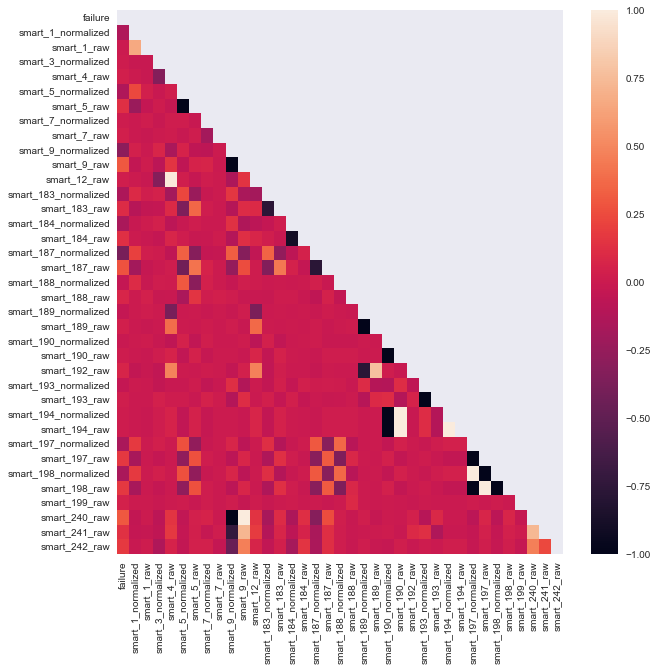

In [23]:
# create correlation matrix over all features
corr_mat = test_model_total.corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix)

In [24]:
# reset the index of the correlation matrix for further analysis (to find the features with the strongest correlation with failure)
corr_mat.reset_index(inplace=True)

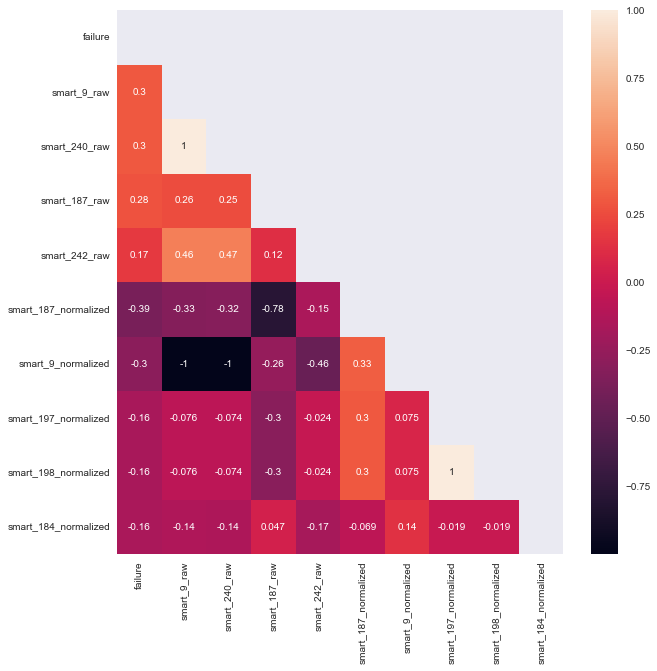

In [25]:
# reduce the correlation features to the most important ones
correlation_features = []

# identify the features with the highest positive correlation
for element in corr_mat.nlargest(5,'failure')['index']:
    correlation_features.append(element)

# identify the features with the highest negative correlation
for element in corr_mat.nsmallest(5,'failure')['index']:
    correlation_features.append(element)

# create correlation matrix over the top 10 features
corr_mat = test_model_total[correlation_features].corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix, annot=True)

#### Mutual Info

Split the data into X and y variables to check the mutual dependency of the different features in regards to the target variable

In [26]:
# split the data into X and y / focus on the most important features
X = test_model_total[correlation_features].drop('failure', axis=1)
y = test_model_total.failure

# create the mutual info classifier
mutual_info = mutual_info_classif(X, y)

# create a column list of the features used
columns = X.columns.to_list()

# concat the column names and the result from mutual_info
evaluation = pd.concat({"columns":pd.Series(columns),
                        'mutual_info': pd.Series(mutual_info)},
                         axis=1, ignore_index=True
)

evaluation.columns = ['feature', 'mutual_info']

display(evaluation.sort_values('mutual_info', ascending=False))

,feature,mutual_info
2,smart_187_raw,0.088271
1,smart_240_raw,0.061266
4,smart_187_normalized,0.056786
5,smart_9_normalized,0.056744
7,smart_198_normalized,0.056324
0,smart_9_raw,0.055542
6,smart_197_normalized,0.052832
3,smart_242_raw,0.019944
8,smart_184_normalized,0.000000


## Features

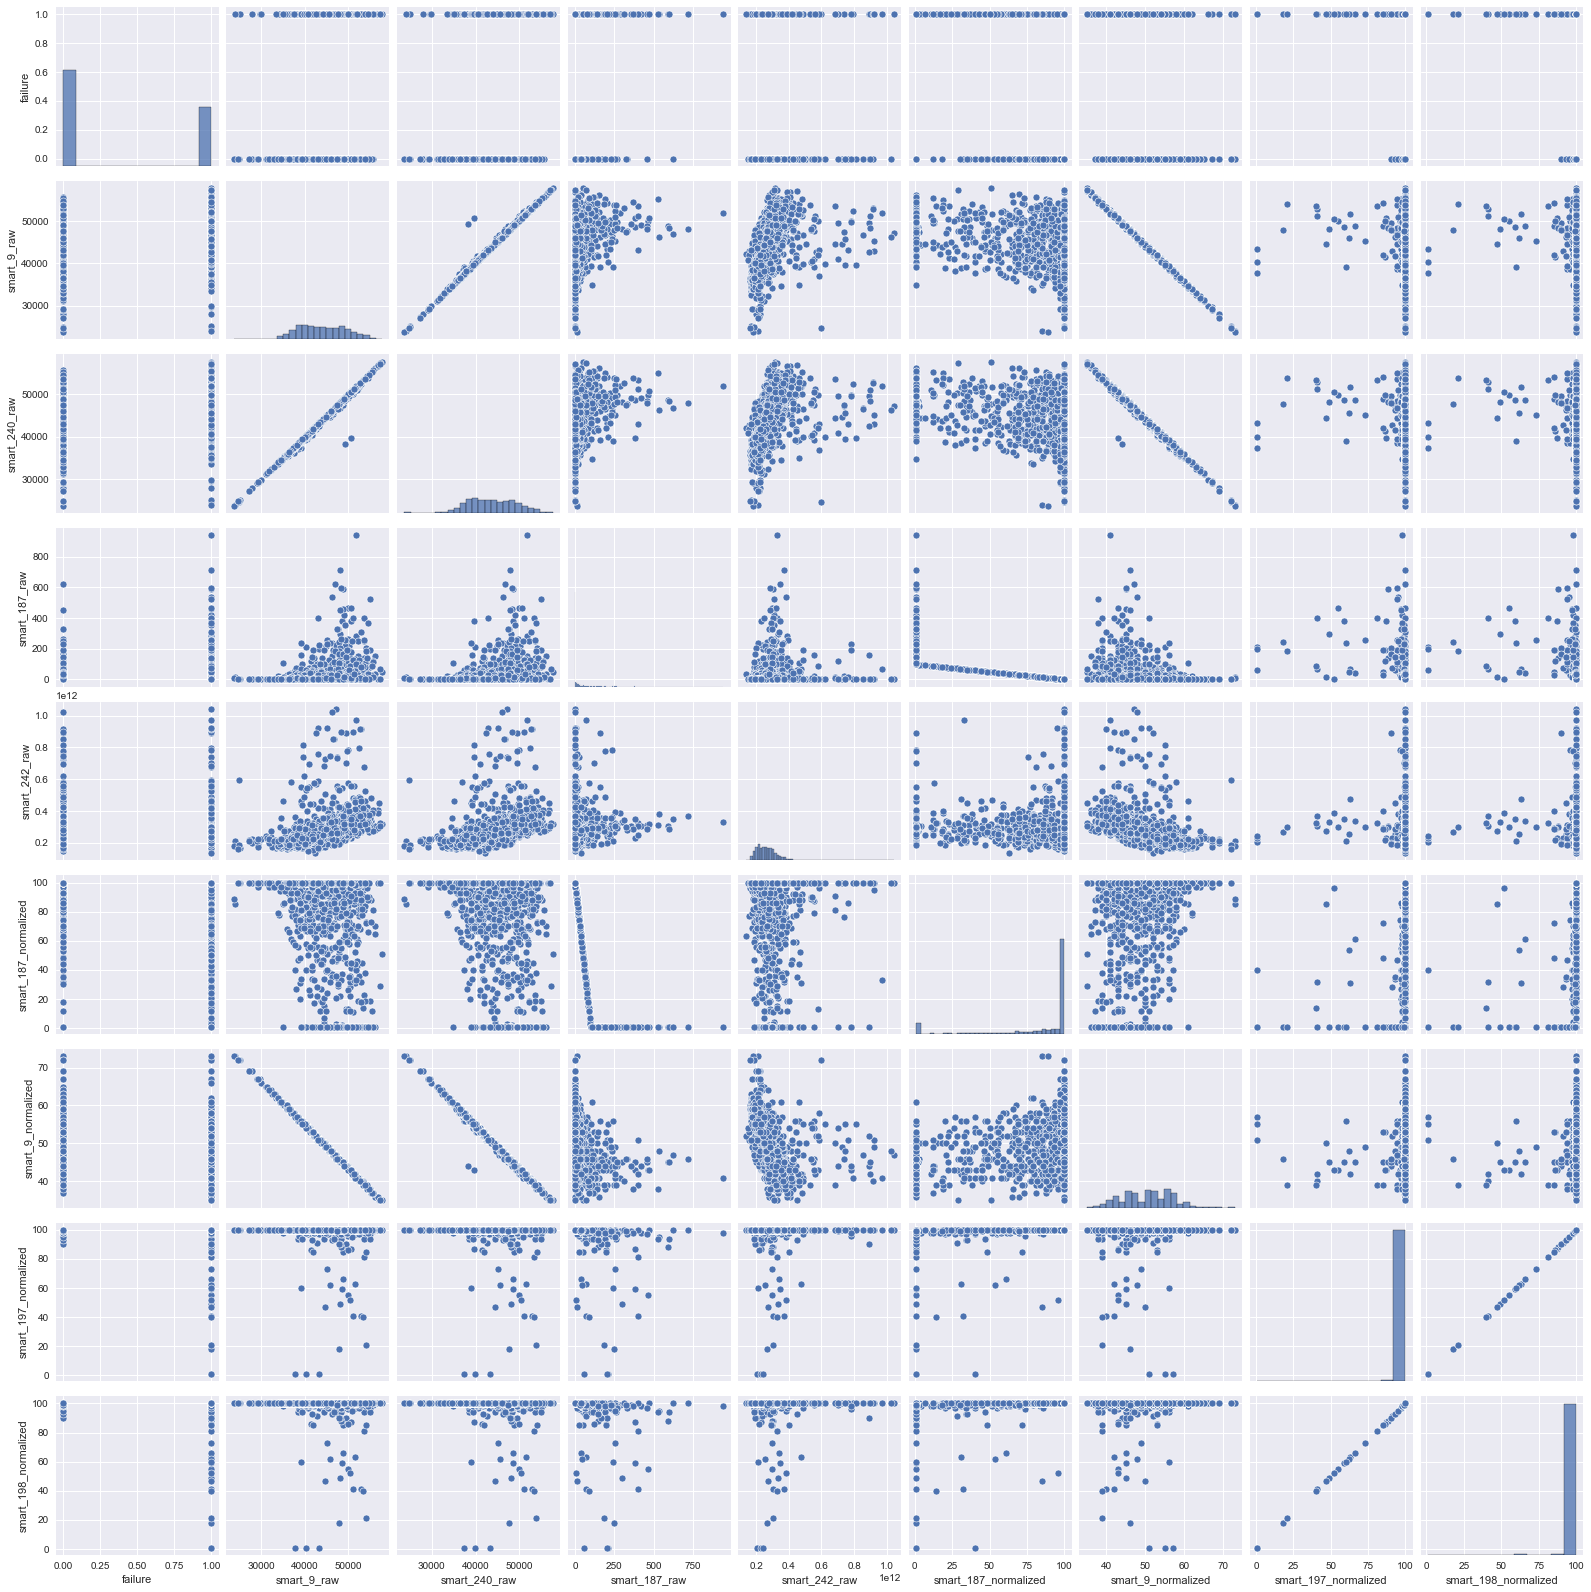

In [27]:
pairplot = test_model_total[correlation_features].reset_index()
sns.pairplot(pairplot.iloc[: ,1:-1]); 

In [28]:
all_columns = test_model_total.columns.to_list()

raw = []
norm = []

for element in all_columns:
    if 'raw' in element:
        raw.append(element)
    elif 'normalized' in element:
        norm.append(element)
    else:
        continue

raw_columns = []
norm_columns = []

for i in range(1, 255):
    if f'smart_{i}_raw'in raw and f'smart_{i}_normalized' in norm:
        raw_columns.append(f'smart_{i}_raw')
        norm_columns.append(f'smart_{i}_normalized')

feature = []

for element in raw_columns:
    feature.append(element.split('_')[1])

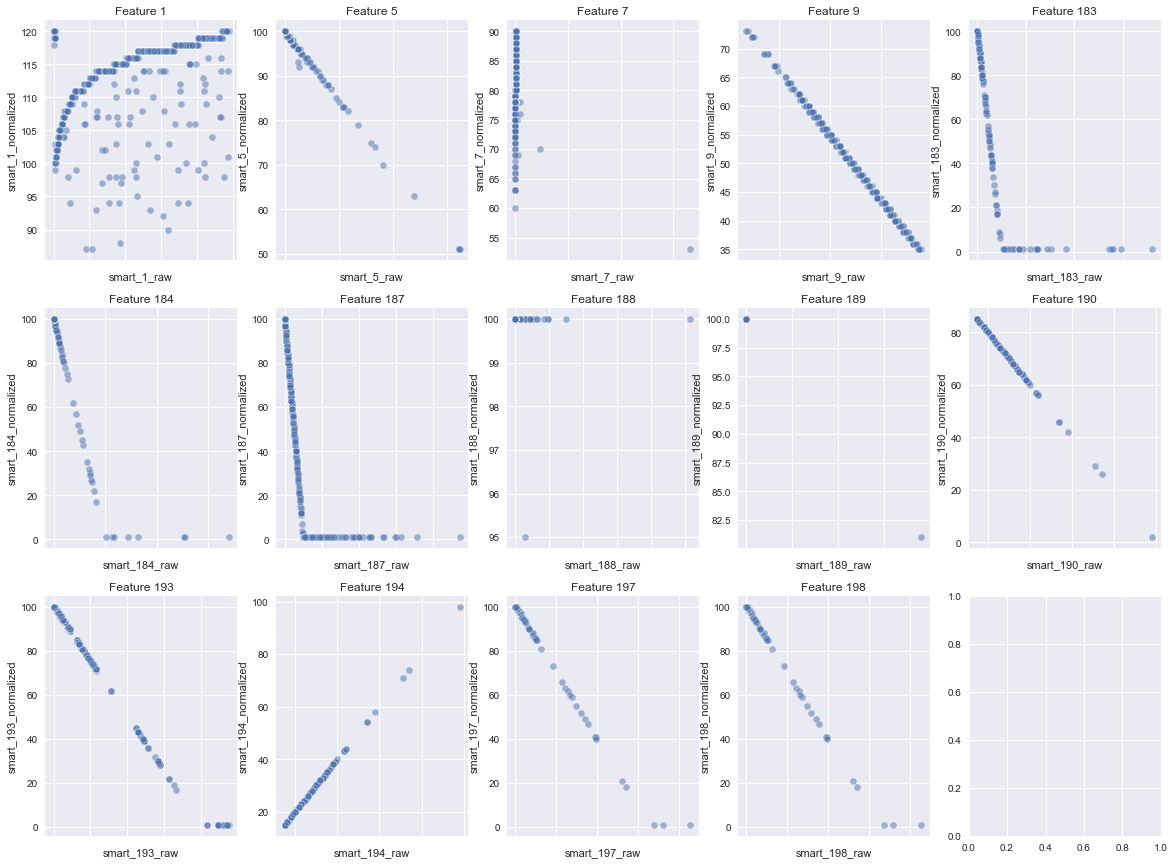

In [29]:
fig, ax = plt.subplots(3, 5, figsize=(20, 15))
counter = 0

for ind, val in enumerate(feature):
    sns.scatterplot(x=test_model_total[f'smart_{val}_raw'], y=test_model_total[f'smart_{val}_normalized'], ax=ax[counter, ind % 5], alpha=0.5)
    ax[counter, ind % 5].set_title(f'Feature {val}')
    ax[counter, ind % 5].set_xticklabels(ax[counter, ind % 5].get_xticklabels(), rotation=90)
    if ind == 4 or ind == 9 or ind == 14:
        counter += 1;

## Load the main data set

In [30]:
import pandas as pd

# load the whole failure history data for one specific model (full history)
test_model_history = pd.read_csv('../data/raw/ST4000DM000_history_total.csv', parse_dates=['date'])
test_model_history.shape

(463089, 179)

In [31]:
#test_model_failure = pd.read_csv('../data/special_purpose/ST4000DM000_failure.csv', parse_dates=['date'])
test_model_history.drop_duplicates(keep='first', inplace=True)

test_model_failure = test_model_history.query('failure == 1')
test_model_failure.sort_values('date', inplace=True)

## Create function for countdown target

In [32]:
# create a date_failure column
test_model_history['date_failure'] = test_model_history['serial_number'].map(test_model_failure.set_index('serial_number')['date'])

In [33]:
test_model_history.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw,date_failure
0,2020-09-18,Z304JG86,ST4000DM000,4000787030016,0,115.0,93783288.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-07
1,2020-09-18,S301GMGZ,ST4000DM000,4000787030016,0,113.0,55185864.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-31
2,2020-09-18,S300YQTN,ST4000DM000,4000787030016,0,118.0,170426904.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-28
3,2020-09-18,Z302T8AB,ST4000DM000,4000787030016,0,117.0,119029336.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-04
4,2020-09-18,Z302SXFH,ST4000DM000,4000787030016,0,108.0,18778216.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-22


In [34]:
# drop columns that have over 40% of NaNs
drop_columns = test_model_history.columns[test_model_history.notna().sum() < (0.4 * len(test_model_history))]
test_model_history.drop(drop_columns, axis=1, inplace=True)

In [35]:
# create a new column called countdown
test_model_history['countdown'] = (test_model_history['date_failure'] - test_model_history['date']).dt.days

In [36]:
test_model_history.query('serial_number == "S301GMGZ"').sort_values('countdown', ascending=True).head(2)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,date_failure,countdown
435732,2021-05-31,S301GMGZ,ST4000DM000,4000787030016,1,118.0,173481632.0,91.0,0.0,100.0,...,200.0,0.0,100.0,48902.0,100.0,6.318903e+10,100.0,3.147592e+11,2021-05-31,0
434613,2021-05-30,S301GMGZ,ST4000DM000,4000787030016,0,117.0,164810784.0,91.0,0.0,100.0,...,200.0,0.0,100.0,48878.0,100.0,6.316468e+10,100.0,3.145541e+11,2021-05-31,1


In [37]:
# drop rows which do not contain any smart data
test_model_history.dropna(how='any', inplace=True)
test_model_history.shape

(462881, 55)

In [38]:
# remove data where countdown is negative (e.g. where a hard drive has been repaired/restored after failure without new failure date)
test_model_history = test_model_history.query('countdown >= 0')

In [39]:
# check for one serial number and return data frame
serial = test_model_history.loc[0, 'serial_number']
test_model_history[test_model_history['serial_number'] == serial].sort_values('countdown',ascending=True)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,date_failure,countdown
60677,2020-11-07,Z304JG86,ST4000DM000,4000787030016,1,117.0,151016424.0,91.0,0.0,100.0,...,200.0,0.0,100.0,43525.0,100.0,5.582141e+10,100.0,2.887075e+11,2020-11-07,0
61820,2020-11-06,Z304JG86,ST4000DM000,4000787030016,0,117.0,153667840.0,91.0,0.0,100.0,...,200.0,0.0,100.0,43501.0,100.0,5.580178e+10,100.0,2.884086e+11,2020-11-07,1
59910,2020-11-05,Z304JG86,ST4000DM000,4000787030016,0,114.0,68578712.0,91.0,0.0,100.0,...,200.0,0.0,100.0,43478.0,100.0,5.578958e+10,100.0,2.881617e+11,2020-11-07,2
59520,2020-11-04,Z304JG86,ST4000DM000,4000787030016,0,113.0,57682176.0,91.0,0.0,100.0,...,200.0,0.0,100.0,43454.0,100.0,5.577502e+10,100.0,2.878911e+11,2020-11-07,3
63356,2020-11-03,Z304JG86,ST4000DM000,4000787030016,0,115.0,94050408.0,91.0,0.0,100.0,...,200.0,0.0,100.0,43430.0,100.0,5.576137e+10,100.0,2.876244e+11,2020-11-07,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287030,2019-01-05,Z304JG86,ST4000DM000,4000787030016,0,119.0,218092400.0,92.0,0.0,100.0,...,200.0,0.0,100.0,27410.0,100.0,4.519800e+10,100.0,1.208970e+11,2020-11-07,672
291890,2019-01-04,Z304JG86,ST4000DM000,4000787030016,0,119.0,217666344.0,92.0,0.0,100.0,...,200.0,0.0,100.0,27387.0,100.0,4.519229e+10,100.0,1.207524e+11,2020-11-07,673
277323,2019-01-03,Z304JG86,ST4000DM000,4000787030016,0,118.0,176805800.0,92.0,0.0,100.0,...,200.0,0.0,100.0,27363.0,100.0,4.519032e+10,100.0,1.206076e+11,2020-11-07,674
280362,2019-01-02,Z304JG86,ST4000DM000,4000787030016,0,113.0,50913560.0,92.0,0.0,100.0,...,200.0,0.0,100.0,27339.0,100.0,4.518756e+10,100.0,1.204436e+11,2020-11-07,675


## Correlation for Countdown

In [40]:
# check columns which only contain 0 values and drop them from the data frame
drop_columns = test_model_history.describe().T.query('mean == 0').reset_index()['index'].to_list()
test_model_history.drop(drop_columns, axis=1, inplace=True)
test_model_history.shape

(462799, 52)

In [41]:
test_model_history.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,...,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,date_failure,countdown
0,2020-09-18,Z304JG86,ST4000DM000,4000787030016,0,115.0,93783288.0,91.0,100.0,13.0,...,200.0,0.0,100.0,42329.0,100.0,5.519570e+10,100.0,2.709359e+11,2020-11-07,50
1,2020-09-18,S301GMGZ,ST4000DM000,4000787030016,0,113.0,55185864.0,91.0,100.0,13.0,...,200.0,0.0,100.0,42778.0,100.0,5.982921e+10,100.0,2.557590e+11,2021-05-31,255
2,2020-09-18,S300YQTN,ST4000DM000,4000787030016,0,118.0,170426904.0,94.0,100.0,6.0,...,200.0,0.0,100.0,46671.0,100.0,6.363719e+10,100.0,2.580255e+11,2021-05-28,252
3,2020-09-18,Z302T8AB,ST4000DM000,4000787030016,0,117.0,119029336.0,92.0,100.0,27.0,...,200.0,0.0,100.0,43845.0,100.0,6.252935e+10,100.0,2.568232e+11,2020-12-04,77
4,2020-09-18,Z302SXFH,ST4000DM000,4000787030016,0,108.0,18778216.0,92.0,100.0,8.0,...,200.0,57.0,100.0,44350.0,100.0,6.250835e+10,100.0,2.357636e+11,2020-09-22,4


In [42]:
# construct correlation matrix
corr_mat = test_model_history.corr()

# drop columns which have no correlation at all
drop_columns = corr_mat[corr_mat['failure'].isnull()].reset_index()['index'].to_list()
test_model_history.drop(drop_columns, axis=1, inplace=True)

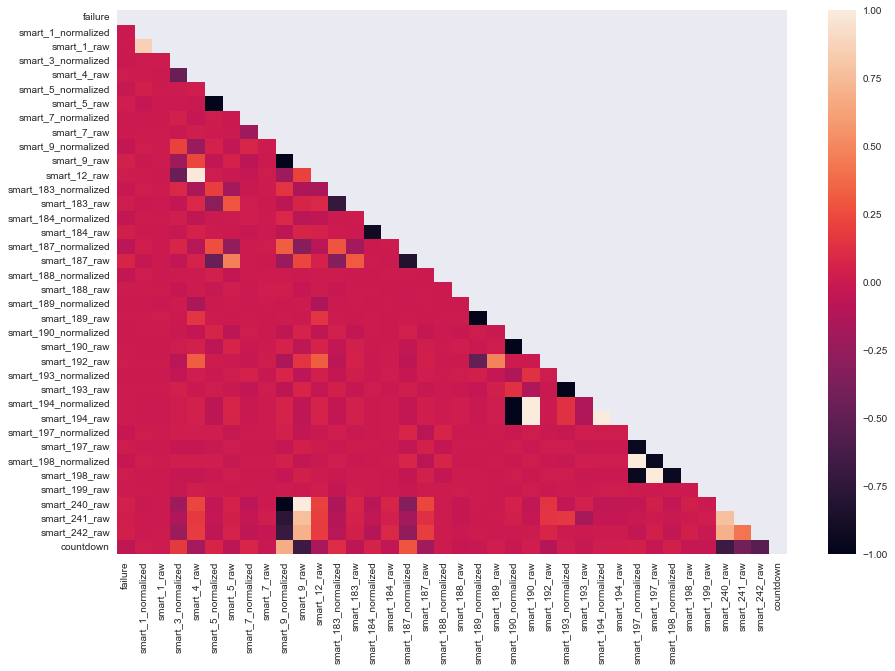

In [43]:
# create correlation matrix over all features
corr_mat = test_model_history.corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(15,10))
g = sns.heatmap(corr_mat, mask=matrix)

In [44]:
# reset the index of the correlation matrix for further analysis (to find the features with the strongest correlation with failure)
corr_mat.reset_index(inplace=True)

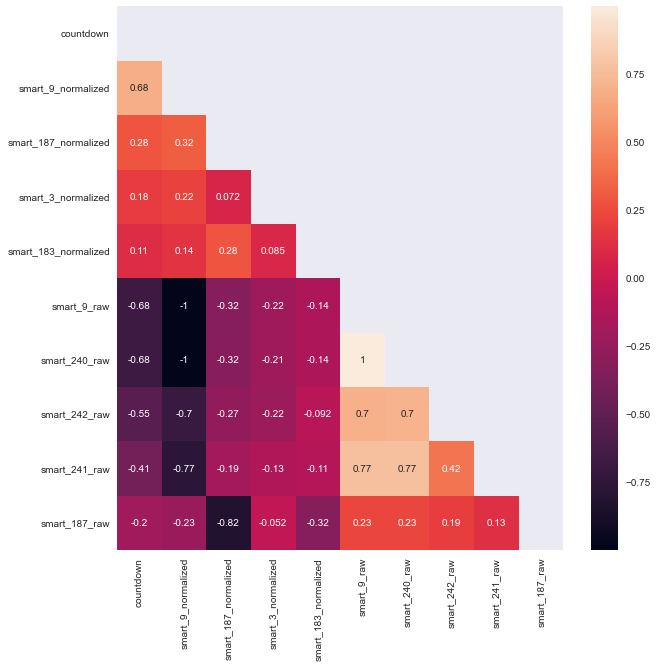

In [45]:
# reduce the correlation features to the most important ones
correlation_features = []

# identify the features with the highest positive correlation
for element in corr_mat.nlargest(5,'countdown')['index']:
    correlation_features.append(element)

# identify the features with the highest negative correlation
for element in corr_mat.nsmallest(5,'countdown')['index']:
    correlation_features.append(element)

# create correlation matrix over the top 10 features
corr_mat = test_model_history[correlation_features].corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix, annot=True)

### Run Time Length

In [257]:
test_model_history['smart_9_years'] = test_model_history['smart_9_raw'] / (24*365.25)
failure = test_model_history.query('failure == 1')

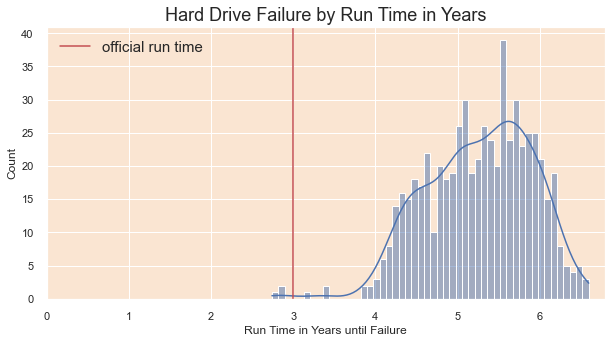

In [258]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=failure['smart_9_years'], kde=True, bins=50)
g.set_title('Hard Drive Failure by Run Time in Years', fontsize=18)
g.set_xlabel("Run Time in Years until Failure")
g.axvline(x=3, c='r', label='official run time')
g.set_xlim(0, )

g.legend(fontsize=15)
plt.savefig('../images/hdd_failure_runtime.png', bbox_inches = "tight")
plt.show()

## Outlier Detection and removal

In [46]:
total_fail = test_model_history.query('failure == 1')
total_healthy = test_model_history.query('failure == 0')

In [47]:
# create a helper column containing the features we want to use for plotting
raw_columns = []

for col in test_model_history.columns:
    if 'raw' in col:
        raw_columns.append(col)

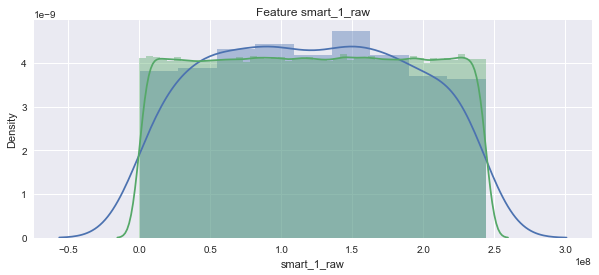

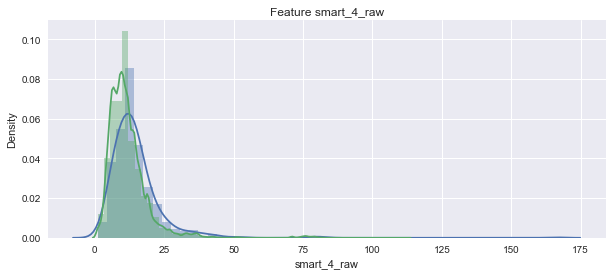

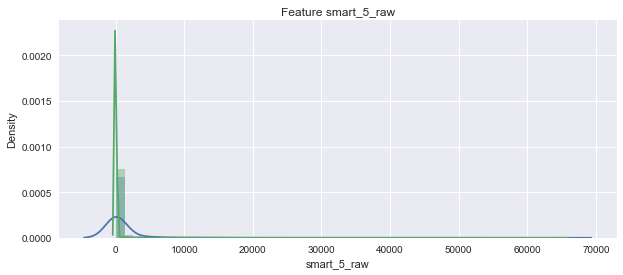

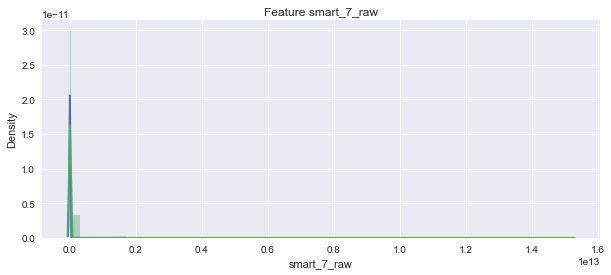

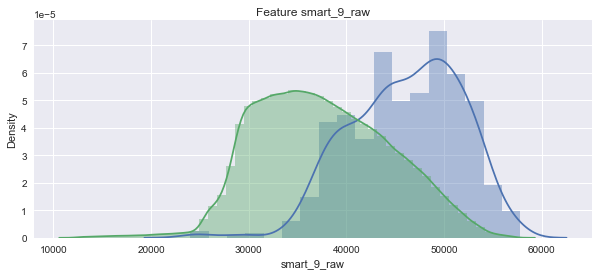

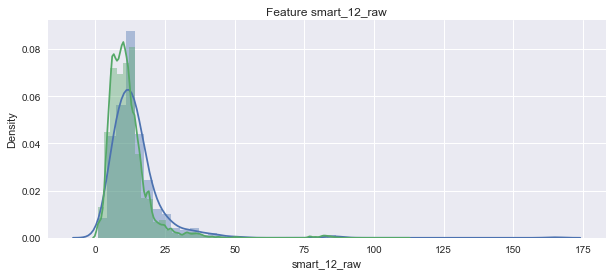

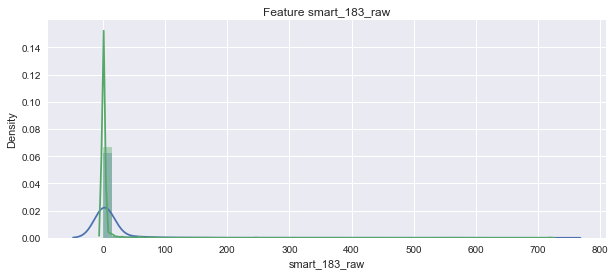

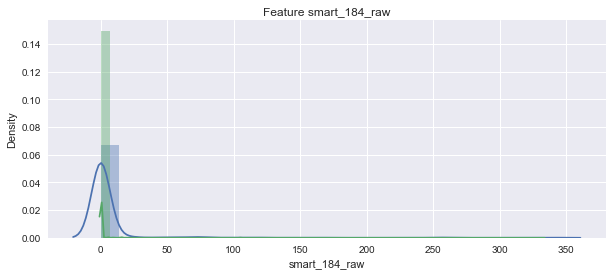

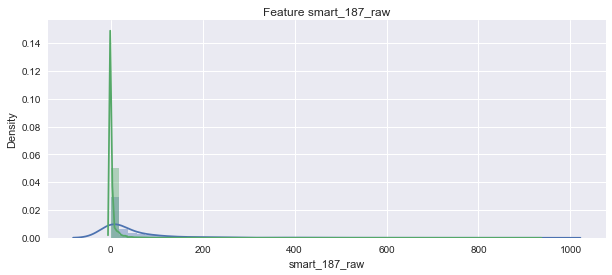

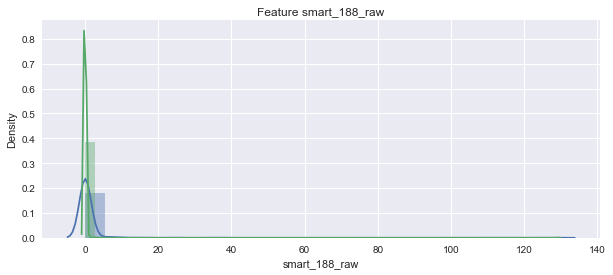

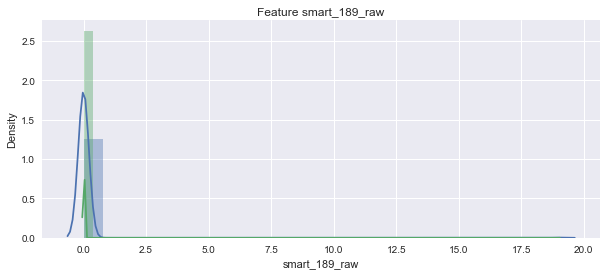

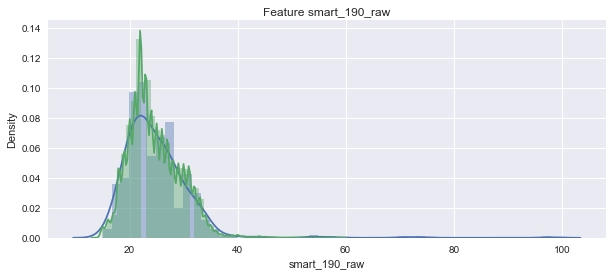

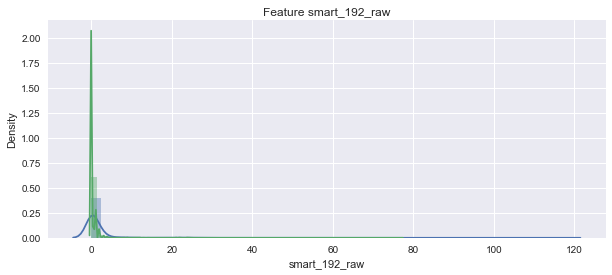

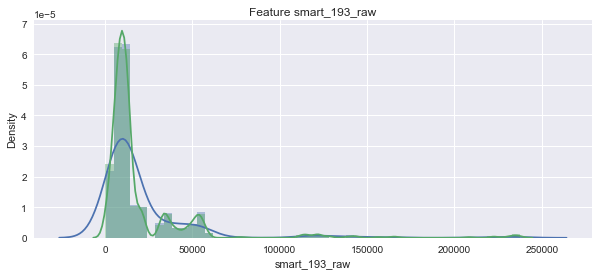

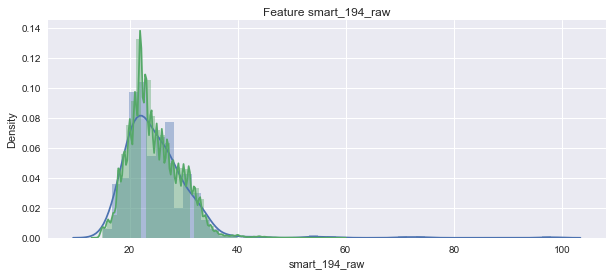

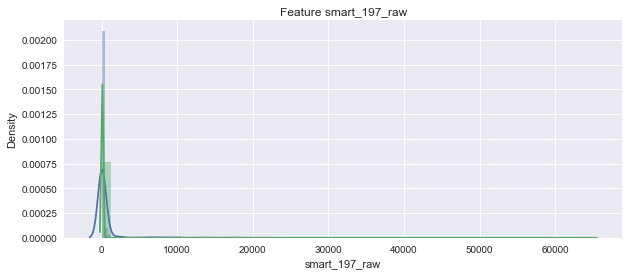

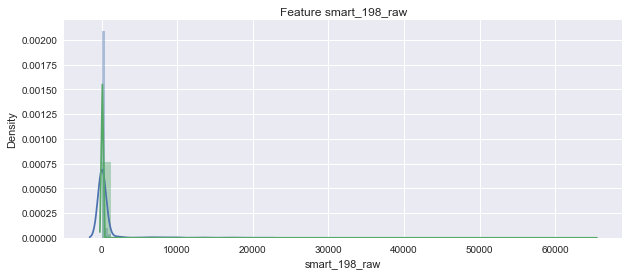

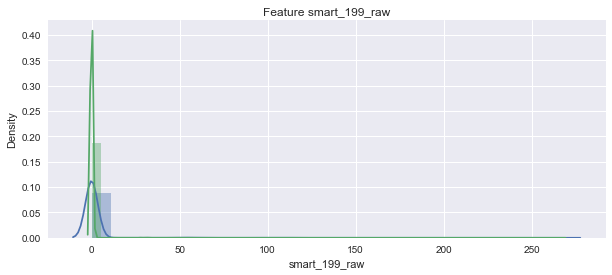

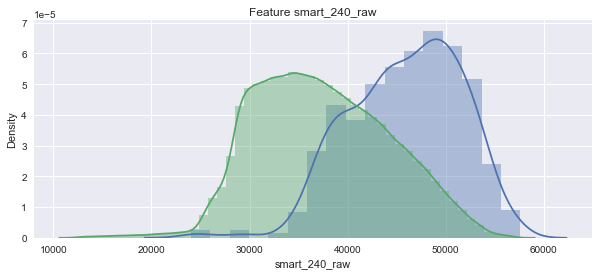

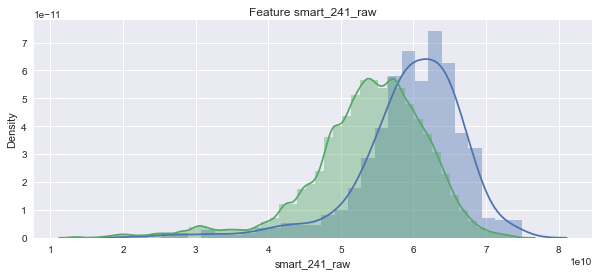

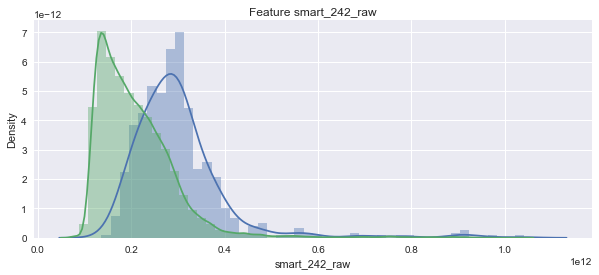

In [48]:
for col in raw_columns:
    plt.subplots(1, 1, figsize=(10, 4))
    g = sns.distplot(total_fail[col], label='failure')
    g = sns.distplot(total_healthy[col], label='no failure')
    g.set_title(f'Feature {col}')

In [254]:
# for col in raw_columns:
#     plt.subplots(1, 1, figsize=(10, 4))
#     g = sns.boxplot(x=test_model_history.failure, y=test_model_history[col])
#     g.set_title(f'Feature {col}');

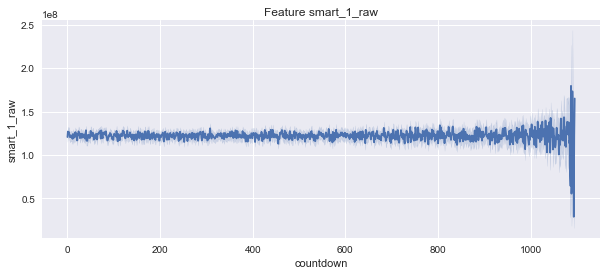

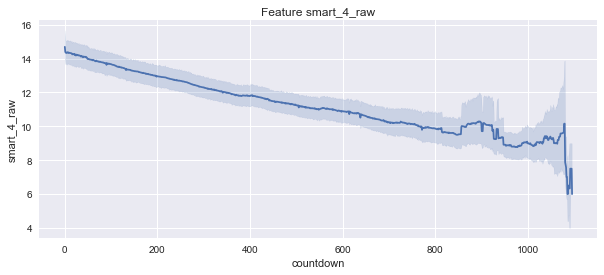

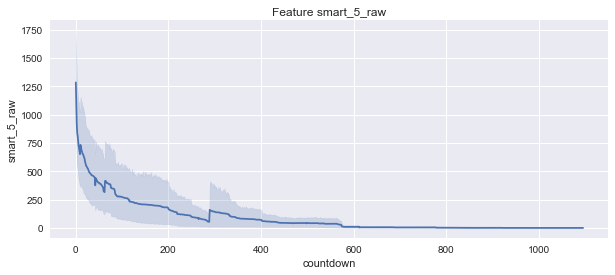

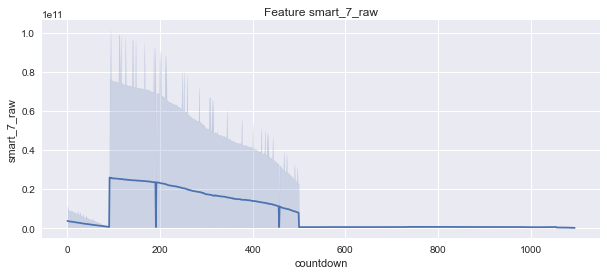

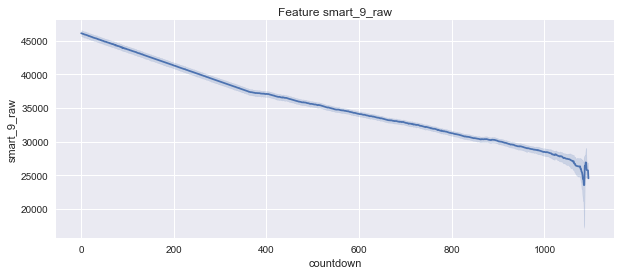

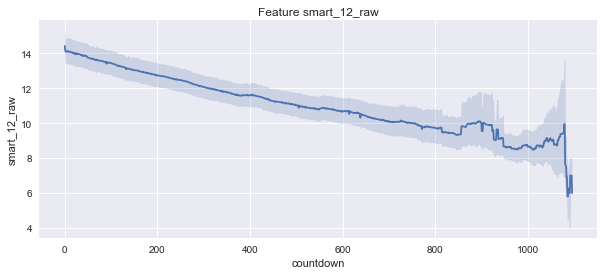

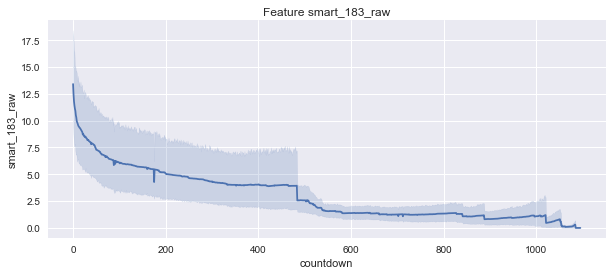

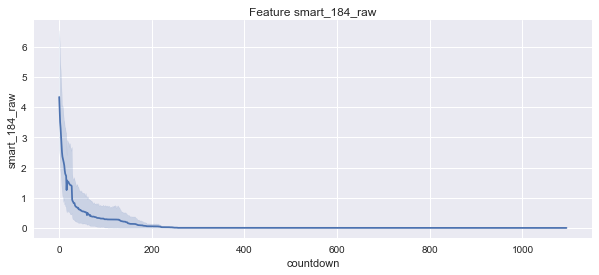

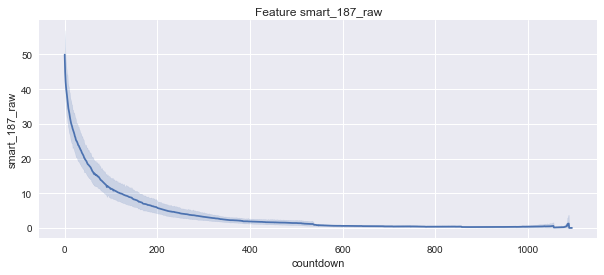

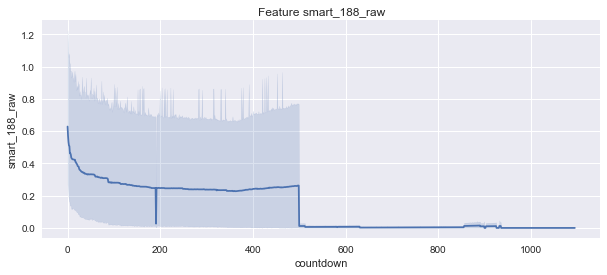

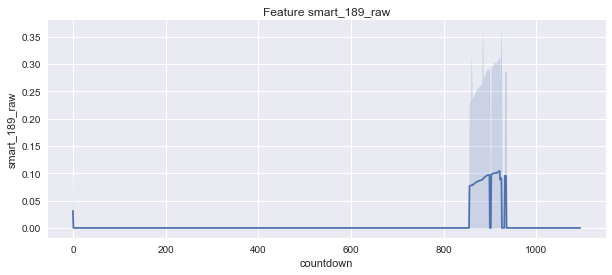

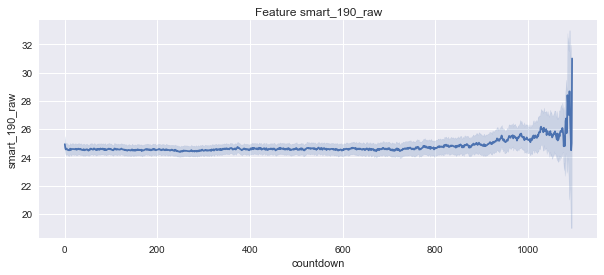

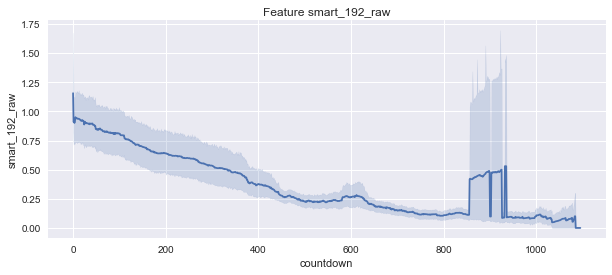

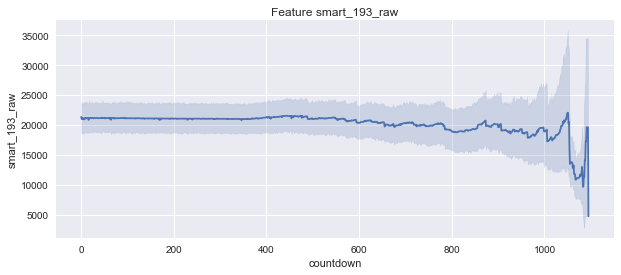

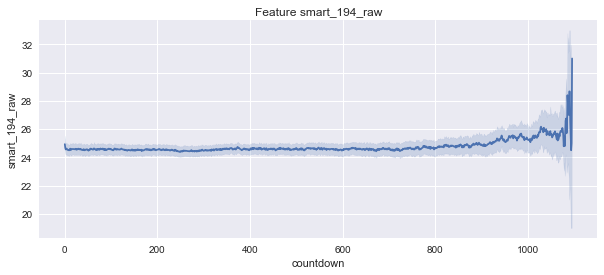

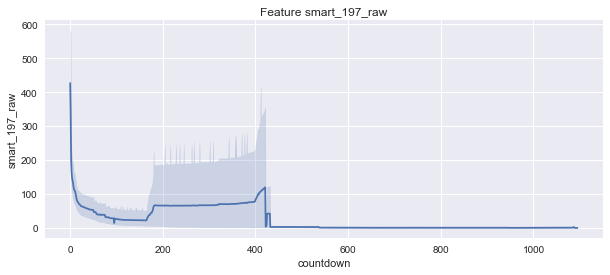

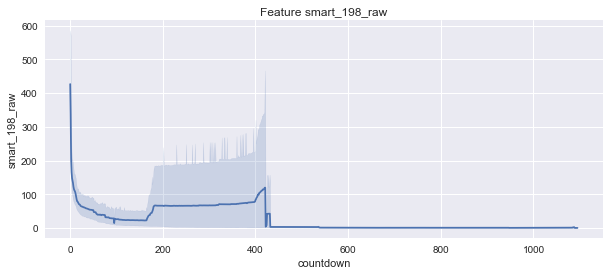

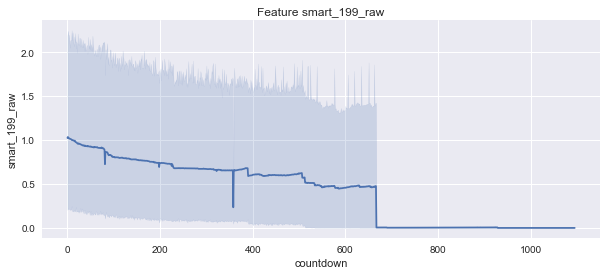

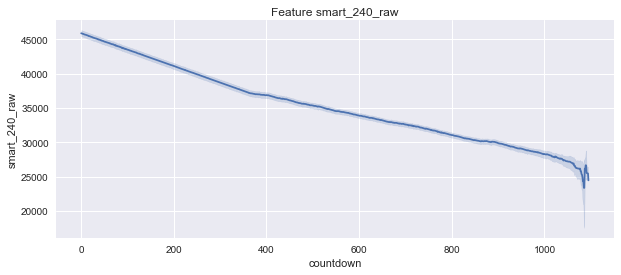

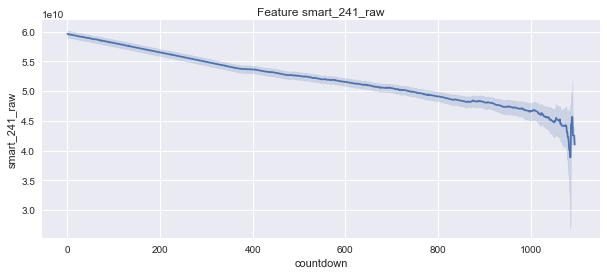

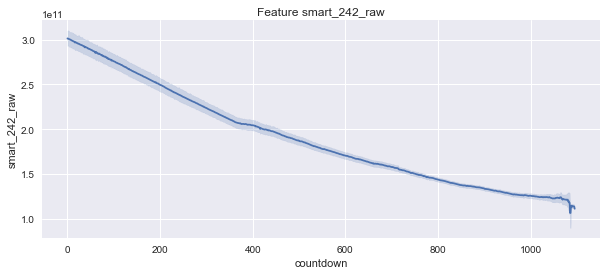

In [50]:
for col in raw_columns:
    plt.subplots(1, 1, figsize=(10, 4))
    g = sns.lineplot(x=test_model_history.countdown, y=test_model_history[col])
    g.set_title(f'Feature {col}');

In [ ]:
test_model_history.to_csv('../data/special_purpose/ST4000DM000_processed_relevant_total_log.csv', index=False)

## Baseline Model - Regression

The first baseline model for the regression classifier will be built using a dummy regressor which takes the mean as the predicted value.

To achieve this task we import the required libraries, define our X and y features, split the data into training and test set and than instanciate the dummy regressor.
In the next step we fit and predict using the dummy regressor and calculate the mean squared error (mse) for the predicted values.


In [ ]:
# Load libraries
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
test_model_history.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
0,2020-09-15,Z304KBK4,ST4000DM000,0,113.0,53991680.0,92.0,14.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43260.0,5.936166e+10,3.123054e+11,2021-12-16,457.0
1,2020-09-15,Z304JGH0,ST4000DM000,0,111.0,31142392.0,91.0,13.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,42459.0,5.902419e+10,2.553616e+11,2021-01-14,121.0
2,2020-09-15,Z302SYHL,ST4000DM000,0,120.0,238681648.0,92.0,22.0,100.0,0.0,...,99.0,184.0,99.0,184.0,0.0,43769.0,6.132206e+10,2.526737e+11,2021-05-22,249.0
3,2020-09-15,S3010L7K,ST4000DM000,0,118.0,180888736.0,94.0,6.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,46589.0,6.335880e+10,2.237496e+11,2020-12-11,87.0
4,2020-09-15,Z304JM6A,ST4000DM000,0,114.0,59625576.0,92.0,16.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43281.0,5.857410e+10,2.774035e+11,2021-01-24,131.0


In [ ]:
# define the X features, droping any feature that is an indication of failure and assigning it to X and saving the target variable into y
X = test_model_history.drop(['failure', 'date', 'date_failure', 'countdown', 'serial_number', 'model'], axis=1)
y = test_model_history.countdown

In [ ]:
# splitting the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# instantiate the dummy regressor and defining the strategy for our baseline predictions
dummy_mean = DummyRegressor(strategy='mean')

# fit the dummy regressor
dummy_mean.fit(X_train, y_train)

# use the dummy regressor to predict the test set
y_test_pred = dummy_mean.predict(X_test)

In [ ]:
# calculate the mean squared error for our test set
mse = mean_squared_error(y_test, y_test_pred)
print(f'The mean squared error for the baseline model is: {round(mse, 3)}')

The mean squared error for the baseline model is: 30728.093


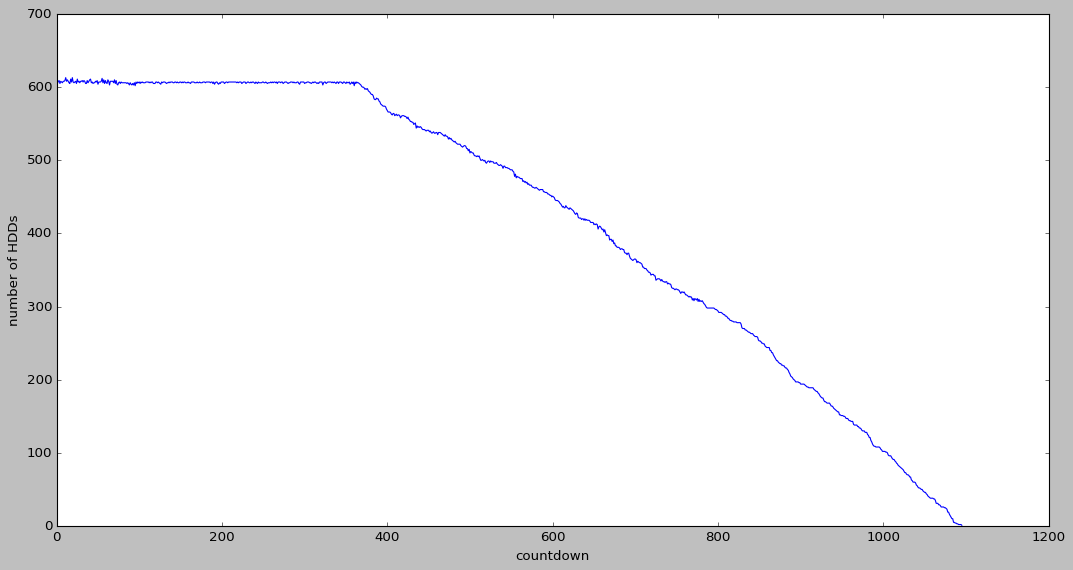

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(data=test_model_history.groupby("countdown").count().date)
plt.ylabel("number of HDDs");

As the amount of hard drives which last longer than 800 is drastically decreasing and not the most interest, we remove everything above 800.

Please keep in mind that this is the Countdown to failure and thus, we remove the very old historical data.

In [255]:
test_model_history = test_model_history.query('countdown <= 800')

# to be deleted

In [ ]:
test_model_history.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
0,2020-09-18,Z304JG86,ST4000DM000,0,115.0,93783288.0,91.0,13.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,2020-11-07,50.0
1,2020-09-18,S301GMGZ,ST4000DM000,0,113.0,55185864.0,91.0,13.0,100.0,0.0,...,100.0,16.0,100.0,16.0,0.0,42778.0,5.982921e+10,2.557590e+11,2021-05-31,255.0
2,2020-09-18,S300YQTN,ST4000DM000,0,118.0,170426904.0,94.0,6.0,100.0,0.0,...,100.0,16.0,100.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11,2021-05-28,252.0
3,2020-09-18,Z302T8AB,ST4000DM000,0,117.0,119029336.0,92.0,27.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,2020-12-04,77.0
4,2020-09-18,Z302SXFH,ST4000DM000,0,108.0,18778216.0,92.0,8.0,100.0,0.0,...,100.0,0.0,100.0,0.0,57.0,44350.0,6.250835e+10,2.357636e+11,2020-09-22,4.0


In [ ]:
test_model_history.query('serial_number == "Z302SQFX" and failure == 1')

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
298155,2021-10-11,Z302SQFX,ST4000DM000,4000787030016,1,111.0,32839264.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298238,2021-10-11,Z302SQFX,ST4000DM000,4000787030016,1,111.0,32839264.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df = pd.read_csv('../data/special_purpose/ST4000DM000_history.csv')
df.head()
failure = df.query('failure==1')['serial_number'].to_list()

In [19]:
failure_selection = df[df['serial_number'] == 'Z302SLCM']
failure_selection.sort_values('date', ascending=False, inplace=True)
failure_data_one = failure_selection[0:30]

failure_selection = df[df['serial_number'] == 'Z3054GHK']
failure_selection.sort_values('date', ascending=False, inplace=True)
failure_data_two = failure_selection[0:30]

failure_selection = df[df['serial_number'] == 'S301NDP6']
failure_selection.sort_values('date', ascending=False, inplace=True)
failure_data_three = failure_selection[0:30]


In [20]:
df_healthy = pd.read_csv('../data/special_purpose/ST4000DM000_healthy_Q1_2021.csv')
first =  df_healthy[df_healthy['serial_number'] == 'Z3058TQY']
second = df_healthy[df_healthy['serial_number'] == 'Z302B0BR']

first.sort_values('date', ascending=False, inplace=True)
second.sort_values('date', ascending=False, inplace=True)
first_df = first[0:30]
second_df = second[0:30]

In [21]:
test_data_new = pd.concat([failure_data_one, failure_data_two, failure_data_three, first_df, second_df], axis=0)

In [24]:
test_data_new.to_csv(f'../data/special_purpose/test_data.csv', index=False)

In [25]:
test_data = pd.read_csv('../data/special_purpose/test_data_temp.csv')
test_data.shape

(150, 179)

In [26]:
test_data.drop_duplicates(inplace=True)
test_data.shape

(150, 179)

In [27]:
test_data = test_data.query('failure == 0')
test_data.shape

In [31]:
test_data.to_csv(f'../data/special_purpose/test_data.csv', index=False)
test_data_new = pd.read_csv('../data/special_purpose/test_data.csv')
test_data_new

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2020-08-30,Z302SLCM,ST4000DM000,4000787030016,0,118.0,190716680.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-29,Z302SLCM,ST4000DM000,4000787030016,0,102.0,186218241.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-28,Z302SLCM,ST4000DM000,4000787030016,0,111.0,40648200.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-08-27,Z302SLCM,ST4000DM000,4000787030016,0,110.0,26023728.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-08-26,Z302SLCM,ST4000DM000,4000787030016,0,115.0,95055152.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2021-03-06,Z302B0BR,ST4000DM000,4000787030016,0,111.0,31511568.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,2021-03-05,Z302B0BR,ST4000DM000,4000787030016,0,117.0,147956488.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,2021-03-04,Z302B0BR,ST4000DM000,4000787030016,0,116.0,101438136.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2021-03-03,Z302B0BR,ST4000DM000,4000787030016,0,116.0,105722968.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2020-09-15,Z304KBK4,ST4000DM000,4000787030016,0,113.0,53991680.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-15,Z304JGH0,ST4000DM000,4000787030016,0,111.0,31142392.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-15,Z302SYHL,ST4000DM000,4000787030016,0,120.0,238681648.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-15,S3010L7K,ST4000DM000,4000787030016,0,118.0,180888736.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-09-15,Z304JM6A,ST4000DM000,4000787030016,0,114.0,59625576.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241966,2020-09-15,Z304KCF4,ST4000DM000,4000787030016,0,119.0,652816.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241967,2020-09-15,Z304JWK4,ST4000DM000,4000787030016,0,113.0,55550656.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241968,2020-09-15,Z304JW0E,ST4000DM000,4000787030016,0,115.0,97844984.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241969,2020-09-15,Z302SW72,ST4000DM000,4000787030016,0,120.0,236908392.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
age_hours = test_model_history.smart_9_raw.mean()

In [39]:
age_days = age_hours/24

In [41]:
age = age_days / 365.25
age

4.29181357709489